In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

In [5]:
from LeNet import LeNet
from data_process import load_data,data_convert
from AdaGrad import AdaGrad

In [6]:
mnist_dir = "./mnist_data/"
train_data_dir = "train-images.idx3-ubyte"
train_label_dir = "train-labels.idx1-ubyte"
test_data_dir = "t10k-images.idx3-ubyte"
test_label_dir = "t10k-labels.idx1-ubyte"

In [7]:
train_images, train_labels, test_images, test_labels = load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir)
print("Got data. ") 

Loading MNIST data from files...
./mnist_data/train-images.idx3-ubyte
Load images from ./mnist_data/train-images.idx3-ubyte, number: 60000, data shape: (60000, 784)
Load images from ./mnist_data/train-labels.idx1-ubyte, number: 60000, data shape: (60000, 1)
Load images from ./mnist_data/t10k-images.idx3-ubyte, number: 10000, data shape: (10000, 784)
Load images from ./mnist_data/t10k-labels.idx1-ubyte, number: 10000, data shape: (10000, 1)
Got data. 


In [8]:
def show_faults(fault_list):
    for i in fault_list:
        img = np.reshape(test_images[i, :], (28, 28))
        label = np.argmax(test_labels [i, :])
        plt.matshow(img, cmap = plt.get_cmap('gray'))
        plt.figure(figsize=(1,1))
        plt.show()

In [9]:
train_images = train_images.astype(float)
x,y = data_convert(train_images, train_labels,60000,10)
x_val , y_val = data_convert(test_images,test_labels,10000,10)

In [10]:
def shuffle_batch(batch_size):

    index = np.random.randint(0,len(x),batch_size)
    return x[index],y.T[index].T

In [17]:
Loss = []
Acc = []
Alpha = []

In [12]:
def softmax(y_pred,y):
    batch_size ,_ = y_pred.shape
    #y_pred = y_pred / y_pred.max(axis=1)[:,None] #防止溢出
    #y_pred+=1e-5
    y_pred = np.exp(y_pred)
    y_sum = y_pred.sum(axis = 1)
    y_pred = y_pred/y_sum[:,None]
    loss = -np.log(y_pred).T * y
    loss = loss.sum()/batch_size
    grad = y_pred - y.T
    grad /= batch_size
    acc = (y_pred.argmax(axis=1) == y.argmax(axis=0)).mean()
    return loss,grad,acc

In [13]:
def cal_accuracy(model,x_val,y_val):
    y_pred = model.fit(x_val,x_val.shape[0])
    _,_,acc = softmax(y_pred,y_val)
    
    return acc

In [14]:
from model import LeNet5
import dataloader
from optimizer import Adam

In [15]:
def softmax_loss(y_pred, y):
    # y_pred: (N, C)
    # y: (N, 1)
    N = y_pred.shape[0]
    ex = np.exp(y_pred)
    sumx = np.sum(ex, axis=1)
    loss = np.mean(np.log(sumx)-y_pred[range(N), list(y)])
    grad = ex/sumx.reshape(N, 1)
    grad[range(N), list(y)] -= 1
    grad /= N
    acc = np.mean(np.argmax(ex/sumx.reshape(N, 1), axis=1) == y.reshape(1, y.shape[0]))
    return loss, grad, acc

In [18]:
batch_size = 256
epochs = 10
lr = 1e-3
data = dataloader.get_mnist_data()
model = LeNet5()
optimizer = Adam(model.get_params(), lr)

for e in range(epochs):
        # add tqdm
    pbar = tqdm(range(0, int(x.shape[0]/batch_size)), ncols=100)
    for i in pbar:
        X, y = dataloader.get_batch(data["X_train"], data["y_train"], batch_size)
        y_pred = model.forward(X)
        loss, grad, acc = softmax_loss(y_pred, y)
        # X_train,y_train = shuffle_batch(batch_size)
        # y_pred = model.forward(X_train.reshape(batch_size,1,28,28))

        # loss, grad, acc = softmax(y_pred, y_train)
        Loss.append(loss)
        Acc.append(acc)
        model.backward(grad)
        #model.update(0.5)
        optimizer.step()
        pbar.set_postfix(loss=loss, acc=acc)

100%|████████████████████████████████████| 234/234 [04:31<00:00,  1.16s/it, acc=0.996, loss=0.00886]


In [11]:
batch_size = 256
model = LeNet()
optimizer = AdaGrad(model,1e-3)
for e in range(1):
    pbar = tqdm(range(0, int(x.shape[0]/batch_size)), ncols=100)
    for i in pbar:
        X_train,y_train = shuffle_batch(batch_size)
        y_pred = model.fit(X_train,batch_size)

        loss, grad, acc = softmax(y_pred, y_train)
        Loss.append(loss)
        Acc.append(acc)
        model.back_prop(grad)
        model.update()
        Alpha.append(model.optimizer.alpha)
        pbar.set_postfix(loss=loss, acc=acc)

  6%|██▏                                     | 13/234 [00:24<07:04,  1.92s/it, acc=0.367, loss=1.88]


KeyboardInterrupt: 

In [13]:
accuracy  = cal_accuracy(model,x_val, y_val)
print("accuracy: {:.2%}".format(accuracy))
print("Finished test. ") 

accuracy: 93.75%
Finished test. 


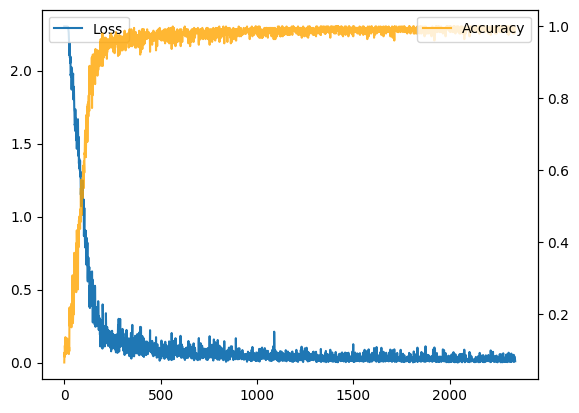

In [19]:
ax = plt.subplot()
sns.lineplot(Loss,ax=ax)
ax2 = ax.twinx()
sns.lineplot(Acc,color = 'orange',alpha = 0.8)

ax.legend(labels = ['Loss'],loc = 'upper left')
ax2.legend(labels = ['Accuracy'],loc = 'upper right')
plt.show()
